In [117]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [118]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
import numpy as np
import trees
from trees.ddt import *
import mpld3
import seaborn as sns
sns.set_style('white')
from tqdm import tqdm
from sklearn.decomposition import PCA

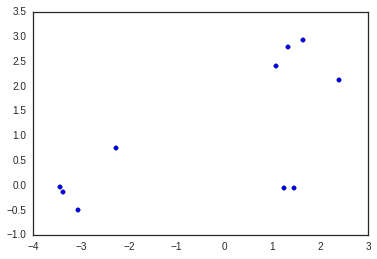

In [119]:
X, y, p = trees.data.load('zoo')
pca = PCA(n_components=2)
X = pca.fit_transform(X)
X += (np.random.uniform(size=X.shape) - 0.5) / 10.0
X = X[20:30]
y = y[20:30]
N, D = X.shape
scatter(*X.T)

INFO:root:Compiling <InverseQuadratic> object...
INFO:root:Done compiling <InverseQuadratic> object.
INFO:root:Compiling <GaussianLikelihoodModel> object...
INFO:root:Done compiling <GaussianLikelihoodModel> object.


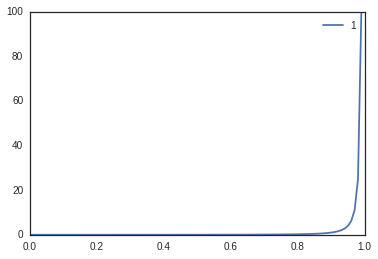

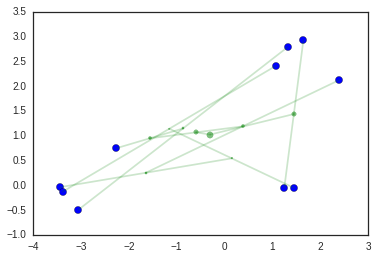

In [120]:
df = InverseQuadratic(b=0, d=0.01).compile()

plt.figure()
plot(arange(0, 1, 0.01), [df.divergence(x) for x in arange(0, 1, 0.01)], label='1')
#plot(arange(0, 1, 0.01), [df2.divergence(x) for x in arange(0, 1, 0.01)], label='2')
legend()

lm = GaussianLikelihoodModel(sigma=np.eye(D) / 1.5, sigma0=np.eye(D) / 10000.0, mu0=X.mean(axis=0)).compile()
gs = GibbsSampler(DirichletDiffusionTree(X, y, df, lm))

def iterate(n_iters):
    lls = []
    for i in tqdm(xrange(n_iters)):
        old_ddt = gs.ddt
        gs.gibbs_sample()
        lls.append(gs.ddt.log_likelihood())
        #if old_ddt != gs.ddt:
        #    logging.info("Iteration %u: %f (accept)" % (i, gs.ddt.log_likelihood()))
        #else:
        #    logging.info("Iteration %u: %f (reject)" % (i, gs.ddt.log_likelihood()))
    return lls

def plot_tree(ddt):
    scatter(*X.T, s=50)
    def plot_node(node, size=40):
        if isinstance(node, Leaf):
            return
        scatter(*node.state, color='g', alpha=0.5,s=size)
        for child in node.children:
            plot(*zip(node.state, child.state), color='g', alpha=0.2)
            plot_node(child, size=size/2)
    plot_node(ddt.root)
plt.figure()
plot_tree(gs.ddt)

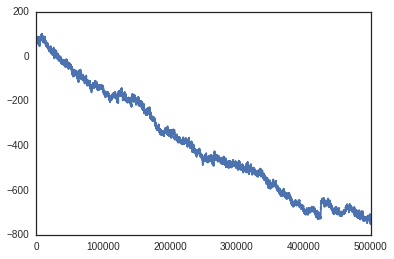

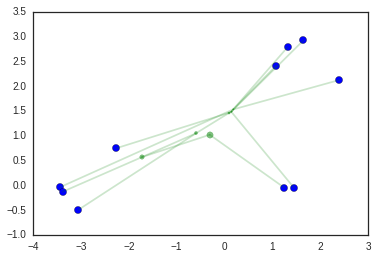

In [132]:
plot(iterate(500000))
figure()
plot_tree(gs.ddt)

-736.045894658 -736.045894658
Rejected


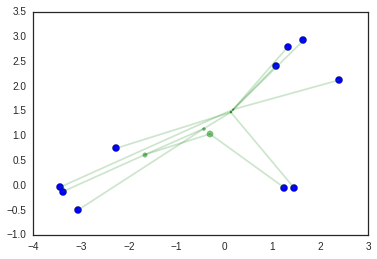

In [186]:
old_ddt = gs.ddt
gs.gibbs_sample()
plot_tree(gs.ddt)
print old_ddt.log_likelihood(), gs.ddt.log_likelihood()
if gs.ddt == old_ddt:
    print "Rejected"
else:
    print "Accepted"

In [133]:
fig = gs.ddt.plot_mpld3()
mpld3.display(fig)

-736.010065995


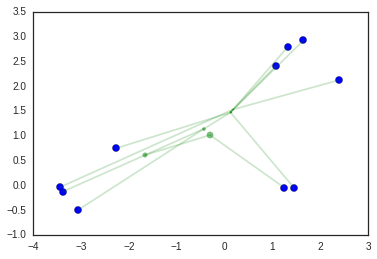

In [206]:
gs.update_latent()
plot_tree(gs.ddt)
print gs.ddt.log_likelihood()

INFO:root:Compiling <InverseQuadratic> object...
INFO:root:Done compiling <InverseQuadratic> object.


array(999.9999999999982)

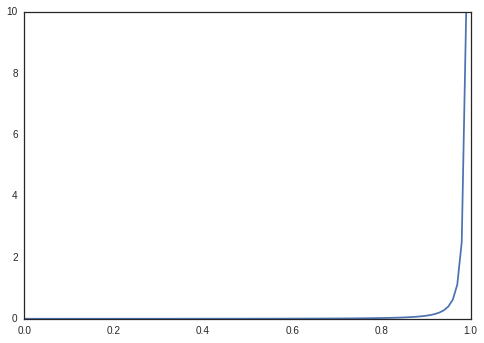

In [17]:
df2 = InverseQuadratic(b=0, d=0.001).compile()
plot(arange(0, 1, 0.01), [df2.divergence(x) for x in arange(0, 1, 0.01)], label='2')
df2.divergence(0.999)

In [19]:
X.mean(axis=0)

array([-0.30238544,  1.01946818])